In [246]:
from matplotlib import pyplot as plt
import numpy as np
import cv2
import glob
import imutils
import os
import pandas as pd
from tqdm import tqdm
from urllib.request import urlretrieve
from os import listdir
from os.path import isfile, join, exists
from zipfile import ZipFile
from scipy.cluster.vq import *

from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.externals import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV

from skimage import exposure
from skimage import feature
from skimage.feature import daisy,hog
from skimage import io
from skimage.color import rgb2gray
import skimage

%matplotlib inline

#hide warnings
import warnings
warnings.filterwarnings('ignore')

In [4]:
def imlist(path):
    """
    The function imlist returns all the names of the files in 
    the directory path supplied as argument to the function.
    """
    return [os.path.join(path, f) for f in os.listdir(path)]

In [81]:
images = glob.glob('Training_set/bridge/*.jpg')

In [229]:
img = cv2.imread(images[3])
img = cv2.resize(img, (300, 300))

In [232]:
images[3]

'Training_set/bridge/gsun_eac4354b6d01693c8ab371c8c9162cdb.jpg'

# 1. Visualization
## 1.1 Greyscale Histogram

(0, 256)

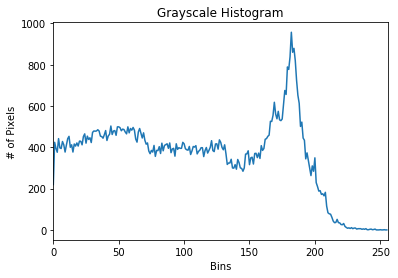

In [230]:
# convert the image to grayscale and create a histogram
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
cv2.imshow("gray", gray)
cv2.waitKey()
hist = cv2.calcHist([gray], [0], None, [256], [0, 256])
plt.figure()
plt.title("Grayscale Histogram")
plt.xlabel("Bins")
plt.ylabel("# of Pixels")
plt.plot(hist)
plt.xlim([0, 256])

In [231]:
cv2.destroyWindow

<function destroyWindow>

## 1.2 Color Histogram

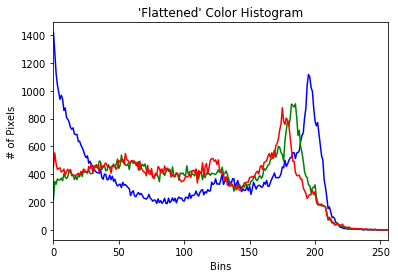

In [233]:
# grab the image channels, initialize the tuple of colors, the figure and the flattened feature vector
chans = cv2.split(img)
colors = ("b", "g", "r")
plt.figure()
plt.title("'Flattened' Color Histogram")
plt.xlabel("Bins")
plt.ylabel("# of Pixels")
features = []

for (chan, color) in zip(chans, colors):
    hist = cv2.calcHist([chan], [0], None, [256], [0, 256])
    features.extend(hist)

    plt.plot(hist, color = color)
    plt.xlim([0, 256])

In [234]:
hist = cv2.calcHist([img], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])

## 1.3 SIFT

In [235]:
sift = cv2.xfeatures2d.SIFT_create()
kp = sift.detect(gray,None)

imgs = cv2.drawKeypoints(gray,kp,img,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
cv2.imwrite('sift_keypoints.jpg',imgs)
cv2.imwrite('gray.jpg',gray)

True

## 1.4 HOG

In [236]:
hog_pixels_per_cell=16
hog_cells_per_block=1

(H, hogImage) = hog(gray, orientations=8, pixels_per_cell=(hog_pixels_per_cell, hog_pixels_per_cell),
                     cells_per_block=(hog_cells_per_block, hog_cells_per_block), visualise=True, feature_vector=True)
hogImage = exposure.rescale_intensity(hogImage, out_range=(0, 255))
hogImage = hogImage.astype("uint8")
 
cv2.imwrite("hog.jpg", hogImage)

True

## 1.5 DAISY

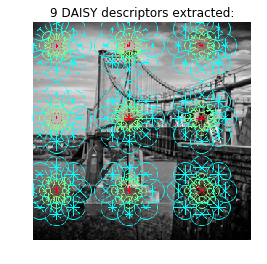

True

In [237]:
descs, descs_img = daisy(gray, step=100, radius=32, rings=2, histograms=8,
                         orientations=8, visualize=True)

fig, ax = plt.subplots()
ax.axis('off')
ax.imshow(descs_img)
descs_num = descs.shape[0] * descs.shape[1]
ax.set_title('%i DAISY descriptors extracted:' % descs_num)
plt.show()

cv2.imwrite("daisy.jpg", descs_img)

# 2. Dataset

In [21]:
def get_filenames(path):
    onlyfiles = [path+f for f in listdir(path) if isfile(join(path, f))]
    return onlyfiles

In [25]:
base_path="Training_set/" #path where image data is kept
category_names=listdir(base_path)
for i in range(len(category_names)):
    print (category_names[i],'=',i)
print ('total categories:',len(category_names))

training_filenames=[] #list to keep path of all training files in the database
training_labels=[]

for category in category_names:
    category_filenames=get_filenames(base_path+category+"/")#get all the filenames in that category
    category_labels=np.ones(len(category_filenames))*category_names.index(category) #label the category with its index position
    training_filenames=training_filenames+category_filenames
    training_labels=training_labels+list(category_labels)

bridge = 0
coast = 1
rainforest = 2
mountain = 3
total categories: 4


In [28]:
print ('total training dataset size:',len(training_filenames))

total training dataset size: 660


In [27]:
base_path="Testing_set/" #path where image data is kept
category_names=listdir(base_path)
for i in range(len(category_names)):
    print (category_names[i],'=',i)
print ('total categories:',len(category_names))

testing_filenames=[] #list to keep path of all training files in the database
testing_labels=[]

for category in category_names:
    category_filenames=get_filenames(base_path+category+"/")#get all the filenames in that category
    category_labels=np.ones(len(category_filenames))*category_names.index(category) #label the category with its index position
    testing_filenames=testing_filenames+category_filenames
    testing_labels=testing_labels+list(category_labels)

bridge = 0
coast = 1
rainforest = 2
mountain = 3
total categories: 4


In [29]:
print ('total testing dataset size:',len(testing_filenames))

total testing dataset size: 140


# 3. DAISY & HOG & Color & SIFT with Linear SVM

In [238]:
# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
def hist_features(image, color_space='RGB', hist_bins=32):     
 
        # Apply color_hist()
        hist_features = color_hist(image, nbins=hist_bins)

        return hist_features

In [116]:
def extract_features(file_path,daisy_step_size=32,daisy_radius=32,hog_pixels_per_cell=16,hog_cells_per_block=1):
    img = io.imread(file_path)
    img_gray = rgb2gray(img)
    im = cv2.imread(file_path)
    im = cv2.resize(im, (300, 300))
    cimg = im
    gray = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
    img = skimage.transform.resize(img_gray,(300,300)) #resize to a suitable dimension, avg size of images in the dataset
    #original, histograms=6
    descs = daisy(img, step=daisy_step_size, radius=daisy_radius, rings=2, histograms=8,orientations=8, visualize=False)
    #calculate daisy feature descriptors
    descs_num = descs.shape[0] * descs.shape[1]
    daisy_descriptors = descs.reshape(descs_num,descs.shape[2])
    hog_descriptor = hog(img, orientations=8, pixels_per_cell=(hog_pixels_per_cell, hog_pixels_per_cell),cells_per_block=(hog_cells_per_block, hog_cells_per_block), visualise=False,feature_vector=True)
    color_hist = hist_features(cimg)
    sift = cv2.xfeatures2d.SIFT_create()
    kpts, des = sift.detectAndCompute(gray, None)
    sift_descriptor = des
    return daisy_descriptors,hog_descriptor,color_hist,sift_descriptor

In [31]:
def plot_file(fname):
    img_data=plt.imread(fname)
    plt.imshow(rgb2gray(img_data),cmap='Greys_r')

DAISY descriptor size: (1296, 136)
HOG descriptor size: (2592,)


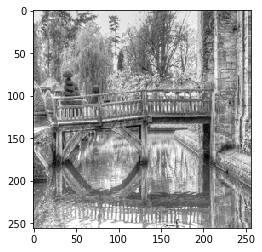

In [40]:
plot_file(training_filenames[0])

daisy_sample,hog_sample=extract_daisy_and_hog_features_from_image(training_filenames[0],daisy_step_size=8,daisy_radius=8)
print ('DAISY descriptor size:',daisy_sample.shape)
print ('HOG descriptor size:',hog_sample.shape)

In [43]:
img_width=300
img_height=300
hog_pixels_per_cell=16
orientations=8
print ('HOG vector size=',int(img_width/hog_pixels_per_cell)*int(img_height/hog_pixels_per_cell)*orientations)

HOG vector size= 2592


In [117]:
training_data_feature_map={} #map to store daisy feature as well as hog feature for all training datapoints
daisy_descriptor_list=[] #list to store all daisy descriptors to form our visual vocabulary by clustering
sift_descriptor_list=[] #list to store all daisy descriptors to form our visual vocabulary by clustering
counter=0
for fname in tqdm(training_filenames):
    daisy_features,hog_feature,color_feature,sift_features=extract_features(fname,daisy_step_size=8,daisy_radius=8)
    #extract DAISY features and HOG features from the image and save in a map
    training_data_feature_map[fname]=[daisy_features,hog_feature,color_feature,sift_features]
    daisy_descriptor_list=daisy_descriptor_list+list(daisy_features)
    sift_descriptor_list=sift_descriptor_list+list(sift_features)





  0%|          | 0/660 [00:00<?, ?it/s]



  0%|          | 1/660 [00:00<02:12,  4.98it/s]



  0%|          | 2/660 [00:00<02:08,  5.11it/s]



  0%|          | 3/660 [00:00<02:06,  5.20it/s]



  1%|          | 4/660 [00:00<01:58,  5.53it/s]



  1%|          | 5/660 [00:00<01:56,  5.61it/s]



  1%|          | 6/660 [00:01<01:55,  5.65it/s]



  1%|          | 7/660 [00:01<01:53,  5.77it/s]



  1%|          | 8/660 [00:01<01:52,  5.78it/s]



  1%|▏         | 9/660 [00:01<01:53,  5.73it/s]



  2%|▏         | 10/660 [00:01<01:51,  5.84it/s]



  2%|▏         | 11/660 [00:01<01:49,  5.90it/s]



  2%|▏         | 12/660 [00:02<01:55,  5.62it/s]



  2%|▏         | 13/660 [00:02<01:55,  5.62it/s]



  2%|▏         | 14/660 [00:02<01:54,  5.62it/s]



  2%|▏         | 15/660 [00:02<01:50,  5.82it/s]



  2%|▏         | 16/660 [00:02<01:48,  5.94it/s]



  3%|▎         | 17/660 [00:02<01:45,  6.07it/s]



  3%|▎         | 18/660 [00:03<01:43,  6.18it/s]



  3%|▎         | 19/660 [0

 19%|█▉        | 127/660 [00:23<01:36,  5.51it/s]



 19%|█▉        | 128/660 [00:23<01:39,  5.35it/s]



 20%|█▉        | 129/660 [00:24<01:37,  5.47it/s]



 20%|█▉        | 130/660 [00:24<01:34,  5.59it/s]



 20%|█▉        | 131/660 [00:24<01:32,  5.70it/s]



 20%|██        | 132/660 [00:24<01:30,  5.84it/s]



 20%|██        | 133/660 [00:24<01:31,  5.78it/s]



 20%|██        | 134/660 [00:25<01:31,  5.75it/s]



 20%|██        | 135/660 [00:25<01:32,  5.69it/s]



 21%|██        | 136/660 [00:25<01:31,  5.76it/s]



 21%|██        | 137/660 [00:25<01:29,  5.82it/s]



 21%|██        | 138/660 [00:25<01:29,  5.86it/s]



 21%|██        | 139/660 [00:25<01:28,  5.86it/s]



 21%|██        | 140/660 [00:26<01:28,  5.89it/s]



 21%|██▏       | 141/660 [00:26<01:28,  5.89it/s]



 22%|██▏       | 142/660 [00:26<01:25,  6.04it/s]



 22%|██▏       | 143/660 [00:26<01:24,  6.12it/s]



 22%|██▏       | 144/660 [00:26<01:24,  6.12it/s]



 22%|██▏       | 145/660 [00:26<01:23,  6.14it

 38%|███▊      | 253/660 [00:45<01:07,  5.99it/s]



 38%|███▊      | 254/660 [00:45<01:07,  6.02it/s]



 39%|███▊      | 255/660 [00:45<01:07,  5.98it/s]



 39%|███▉      | 256/660 [00:45<01:09,  5.83it/s]



 39%|███▉      | 257/660 [00:45<01:16,  5.25it/s]



 39%|███▉      | 258/660 [00:46<01:18,  5.12it/s]



 39%|███▉      | 259/660 [00:46<01:14,  5.41it/s]



 39%|███▉      | 260/660 [00:46<01:13,  5.46it/s]



 40%|███▉      | 261/660 [00:46<01:09,  5.74it/s]



 40%|███▉      | 262/660 [00:46<01:06,  5.97it/s]



 40%|███▉      | 263/660 [00:46<01:04,  6.16it/s]



 40%|████      | 264/660 [00:47<01:02,  6.32it/s]



 40%|████      | 265/660 [00:47<01:01,  6.38it/s]



 40%|████      | 266/660 [00:47<01:01,  6.38it/s]



 40%|████      | 267/660 [00:47<01:01,  6.43it/s]



 41%|████      | 268/660 [00:47<01:00,  6.44it/s]



 41%|████      | 269/660 [00:47<01:05,  5.98it/s]



 41%|████      | 270/660 [00:48<01:09,  5.65it/s]



 41%|████      | 271/660 [00:48<01:11,  5.47it

 57%|█████▋    | 379/660 [01:07<00:53,  5.28it/s]



 58%|█████▊    | 380/660 [01:07<00:54,  5.17it/s]



 58%|█████▊    | 381/660 [01:07<00:58,  4.74it/s]



 58%|█████▊    | 382/660 [01:08<00:56,  4.88it/s]



 58%|█████▊    | 383/660 [01:08<00:58,  4.73it/s]



 58%|█████▊    | 384/660 [01:08<00:58,  4.75it/s]



 58%|█████▊    | 385/660 [01:08<00:56,  4.83it/s]



 58%|█████▊    | 386/660 [01:08<00:59,  4.61it/s]



 59%|█████▊    | 387/660 [01:09<01:00,  4.51it/s]



 59%|█████▉    | 388/660 [01:09<01:00,  4.49it/s]



 59%|█████▉    | 389/660 [01:09<00:58,  4.67it/s]



 59%|█████▉    | 390/660 [01:09<00:54,  4.97it/s]



 59%|█████▉    | 391/660 [01:09<00:51,  5.18it/s]



 59%|█████▉    | 392/660 [01:10<00:52,  5.08it/s]



 60%|█████▉    | 393/660 [01:10<00:56,  4.76it/s]



 60%|█████▉    | 394/660 [01:10<00:57,  4.60it/s]



 60%|█████▉    | 395/660 [01:10<00:58,  4.50it/s]



 60%|██████    | 396/660 [01:11<00:58,  4.53it/s]



 60%|██████    | 397/660 [01:11<00:58,  4.53it

 77%|███████▋  | 505/660 [01:31<00:33,  4.69it/s]



 77%|███████▋  | 506/660 [01:32<00:32,  4.74it/s]



 77%|███████▋  | 507/660 [01:32<00:31,  4.87it/s]



 77%|███████▋  | 508/660 [01:32<00:32,  4.69it/s]



 77%|███████▋  | 509/660 [01:32<00:32,  4.70it/s]



 77%|███████▋  | 510/660 [01:32<00:29,  5.00it/s]



 77%|███████▋  | 511/660 [01:33<00:28,  5.24it/s]



 78%|███████▊  | 512/660 [01:33<00:28,  5.16it/s]



 78%|███████▊  | 513/660 [01:33<00:28,  5.12it/s]



 78%|███████▊  | 514/660 [01:33<00:27,  5.29it/s]



 78%|███████▊  | 515/660 [01:33<00:26,  5.43it/s]



 78%|███████▊  | 516/660 [01:33<00:26,  5.51it/s]



 78%|███████▊  | 517/660 [01:34<00:25,  5.65it/s]



 78%|███████▊  | 518/660 [01:34<00:24,  5.74it/s]



 79%|███████▊  | 519/660 [01:34<00:24,  5.75it/s]



 79%|███████▉  | 520/660 [01:34<00:24,  5.83it/s]



 79%|███████▉  | 521/660 [01:34<00:23,  5.88it/s]



 79%|███████▉  | 522/660 [01:34<00:23,  5.87it/s]



 79%|███████▉  | 523/660 [01:35<00:23,  5.81it

 96%|█████████▌| 631/660 [01:55<00:05,  5.74it/s]



 96%|█████████▌| 632/660 [01:55<00:04,  5.77it/s]



 96%|█████████▌| 633/660 [01:55<00:04,  5.80it/s]



 96%|█████████▌| 634/660 [01:56<00:04,  5.81it/s]



 96%|█████████▌| 635/660 [01:56<00:04,  5.86it/s]



 96%|█████████▋| 636/660 [01:56<00:04,  5.87it/s]



 97%|█████████▋| 637/660 [01:56<00:03,  5.86it/s]



 97%|█████████▋| 638/660 [01:56<00:03,  5.90it/s]



 97%|█████████▋| 639/660 [01:56<00:03,  5.81it/s]



 97%|█████████▋| 640/660 [01:57<00:03,  5.67it/s]



 97%|█████████▋| 641/660 [01:57<00:03,  5.12it/s]



 97%|█████████▋| 642/660 [01:57<00:03,  5.06it/s]



 97%|█████████▋| 643/660 [01:57<00:03,  5.24it/s]



 98%|█████████▊| 644/660 [01:57<00:02,  5.42it/s]



 98%|█████████▊| 645/660 [01:58<00:02,  5.06it/s]



 98%|█████████▊| 646/660 [01:58<00:02,  5.21it/s]



 98%|█████████▊| 647/660 [01:58<00:02,  5.34it/s]



 98%|█████████▊| 648/660 [01:58<00:02,  5.34it/s]



 98%|█████████▊| 649/660 [01:58<00:02,  5.45it

In [118]:
print ('Total daisy descriptors:',len(daisy_descriptor_list))

Total daisy descriptors: 855360


In [119]:
print ('Total sift descriptors:',len(sift_descriptor_list))

Total sift descriptors: 586297


In [120]:
def cluster_features(feature_list,number_of_clusters):
    km = MiniBatchKMeans(n_clusters=number_of_clusters,batch_size=number_of_clusters*10)
    km.fit(feature_list)
    return km

In [121]:
daisy_cluster_model=cluster_features(daisy_descriptor_list,100) 
daisy_cluster_model.n_clusters

100

In [122]:
sift_cluster_model=cluster_features(sift_descriptor_list,100) 
sift_cluster_model.n_clusters

100

In [126]:
def extract_hybrid_feature(fname,daisy_cluster_model,sift_cluster_model):
    #in case if we have encountered the file during training, the daisy and hog features would already have been computed
    if fname in training_data_feature_map:
        daisy_features=training_data_feature_map[fname][0]
        hog_feature=training_data_feature_map[fname][1]
        color_feature=training_data_feature_map[fname][2]
        sift_features=training_data_feature_map[fname][3]
    else:
        daisy_features,hog_feature,color_feature,sift_features=extract_features(fname,daisy_step_size=8,daisy_radius=8)
        
    #find to which clusters each daisy feature belongs
    daisy_img_clusters=daisy_cluster_model.predict(daisy_features) 
    daisy_cluster_freq_counts=pd.DataFrame(daisy_img_clusters,columns=['cnt'])['cnt'].value_counts()
    daisy_bovw_vector=np.zeros(daisy_cluster_model.n_clusters) #feature vector of size as the total number of clusters
    for key in daisy_cluster_freq_counts.keys():
        daisy_bovw_vector[key]=daisy_cluster_freq_counts[key]
    
    #find to which clusters each daisy feature belongs
    sift_img_clusters=sift_cluster_model.predict(sift_features) 
    sift_cluster_freq_counts=pd.DataFrame(sift_img_clusters,columns=['cnt'])['cnt'].value_counts()
    sift_bovw_vector=np.zeros(sift_cluster_model.n_clusters) #feature vector of size as the total number of clusters
    for key in sift_cluster_freq_counts.keys():
        sift_bovw_vector[key]=sift_cluster_freq_counts[key]

    daisy_bovw_feature=daisy_bovw_vector/np.linalg.norm(daisy_bovw_vector)
    hog_feature=hog_feature/np.linalg.norm(hog_feature)
    color_feature=color_feature/np.linalg.norm(color_feature)
    sift_bovw_feature=sift_bovw_vector/np.linalg.norm(sift_bovw_vector)
    return list(daisy_bovw_feature)+list(hog_feature)+list(color_feature)+list(sift_bovw_feature)

In [127]:
xtrain=[]
ytrain=[]
for i in tqdm(range(len(training_filenames))):
    xtrain.append(extract_hybrid_feature(training_filenames[i],daisy_cluster_model,sift_cluster_model))
    ytrain.append(training_labels[i])





  0%|          | 0/660 [00:00<?, ?it/s]



  2%|▏         | 11/660 [00:00<00:06, 108.14it/s]



  3%|▎         | 22/660 [00:00<00:05, 106.79it/s]



  5%|▌         | 36/660 [00:00<00:05, 114.00it/s]



  7%|▋         | 49/660 [00:00<00:05, 116.98it/s]



  9%|▉         | 62/660 [00:00<00:04, 119.83it/s]



 11%|█▏        | 75/660 [00:00<00:04, 121.08it/s]



 13%|█▎        | 88/660 [00:00<00:04, 121.35it/s]



 15%|█▌        | 101/660 [00:00<00:04, 123.79it/s]



 17%|█▋        | 114/660 [00:00<00:04, 124.38it/s]



 19%|█▉        | 127/660 [00:01<00:04, 124.37it/s]



 21%|██        | 140/660 [00:01<00:04, 120.29it/s]



 23%|██▎       | 152/660 [00:01<00:04, 118.73it/s]



 25%|██▌       | 165/660 [00:01<00:04, 120.49it/s]



 27%|██▋       | 177/660 [00:01<00:04, 110.45it/s]



 29%|██▉       | 190/660 [00:01<00:04, 113.99it/s]



 31%|███       | 203/660 [00:01<00:03, 117.97it/s]



 33%|███▎      | 215/660 [00:01<00:03, 113.31it/s]



 35%|███▍      | 228/660 [00:01<00:03, 117

In [139]:
xtest=[]
ytest=[]
for i in tqdm(range(len(testing_filenames))):
    xtest.append(extract_hybrid_feature(testing_filenames[i],daisy_cluster_model,sift_cluster_model))
    ytest.append(testing_labels[i])





  0%|          | 0/140 [00:00<?, ?it/s]



  1%|          | 1/140 [00:00<00:32,  4.30it/s]



  1%|▏         | 2/140 [00:00<00:29,  4.67it/s]



  2%|▏         | 3/140 [00:00<00:27,  5.07it/s]



  3%|▎         | 4/140 [00:00<00:25,  5.42it/s]



  4%|▎         | 5/140 [00:00<00:23,  5.72it/s]



  4%|▍         | 6/140 [00:01<00:22,  5.92it/s]



  5%|▌         | 7/140 [00:01<00:22,  5.90it/s]



  6%|▌         | 8/140 [00:01<00:22,  5.93it/s]



  6%|▋         | 9/140 [00:01<00:22,  5.93it/s]



  7%|▋         | 10/140 [00:01<00:21,  5.95it/s]



  8%|▊         | 11/140 [00:01<00:21,  6.00it/s]



  9%|▊         | 12/140 [00:02<00:21,  6.05it/s]



  9%|▉         | 13/140 [00:02<00:21,  5.86it/s]



 10%|█         | 14/140 [00:02<00:20,  6.01it/s]



 11%|█         | 15/140 [00:02<00:20,  6.18it/s]



 11%|█▏        | 16/140 [00:02<00:19,  6.26it/s]



 12%|█▏        | 17/140 [00:02<00:19,  6.40it/s]



 13%|█▎        | 18/140 [00:02<00:18,  6.51it/s]



 14%|█▎        | 19/140 [0

 91%|█████████ | 127/140 [00:20<00:02,  6.36it/s]



 91%|█████████▏| 128/140 [00:20<00:01,  6.34it/s]



 92%|█████████▏| 129/140 [00:20<00:01,  6.32it/s]



 93%|█████████▎| 130/140 [00:20<00:01,  6.28it/s]



 94%|█████████▎| 131/140 [00:20<00:01,  6.18it/s]



 94%|█████████▍| 132/140 [00:20<00:01,  6.18it/s]



 95%|█████████▌| 133/140 [00:21<00:01,  6.17it/s]



 96%|█████████▌| 134/140 [00:21<00:00,  6.14it/s]



 96%|█████████▋| 135/140 [00:21<00:00,  6.13it/s]



 97%|█████████▋| 136/140 [00:21<00:00,  6.24it/s]



 98%|█████████▊| 137/140 [00:21<00:00,  6.24it/s]



 99%|█████████▊| 138/140 [00:21<00:00,  6.21it/s]



 99%|█████████▉| 139/140 [00:22<00:00,  6.29it/s]



100%|██████████| 140/140 [00:22<00:00,  6.28it/s]

In [128]:
len(xtrain[0])

2888

In [130]:
xtrain_DAISY = []
for X in xtrain:
    xtrain_DAISY.append(X[:100])
    
xtest_DAISY = []
for X in xtest:
    xtest_DAISY.append(X[:100])

In [134]:
xtrain_HOG = []
for X in xtrain:
    xtrain_HOG.append(X[100:2692])
    
xtest_HOG = []
for X in xtest:
    xtest_HOG.append(X[100:2692])

In [152]:
xtrain_COLOR = []
for X in xtrain:
    xtrain_COLOR.append(X[2692:2788])
    
xtest_COLOR = []
for X in xtest:
    xtest_COLOR.append(X[2692:2788])

In [153]:
xtrain_SIFT = []
for X in xtrain:
    xtrain_SIFT.append(X[2788:])
    
xtest_SIFT = []
for X in xtest:
    xtest_SIFT.append(X[2788:])

In [137]:
hybrid_classifier=svm.LinearSVC()
hybrid_classifier.fit(xtrain,ytrain)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [140]:
print ('Hybrid Classifier Mertics - linear model')
print ('No. of test instances:',len(xtest),len(ytest))

hybridpred=hybrid_classifier.predict(xtest)
print ('Overall accuracy:',accuracy_score(ytest,hybridpred))
print (classification_report(ytest, hybridpred, target_names=category_names))
print ('Confusion matrix:\n')
pd.DataFrame(confusion_matrix(ytest,hybridpred),
             columns=['bridge', 'coast', 'rainforest', 'mountain'],
               index=['bridge', 'coast', 'rainforest', 'mountain'])

Hybrid Classifier Mertics - linear model
No. of test instances: 140 140
Overall accuracy: 0.8642857142857143
              precision    recall  f1-score   support

      bridge       0.80      0.80      0.80        35
       coast       0.86      0.89      0.87        35
  rainforest       0.94      0.91      0.93        35
    mountain       0.86      0.86      0.86        35

   micro avg       0.86      0.86      0.86       140
   macro avg       0.86      0.86      0.86       140
weighted avg       0.86      0.86      0.86       140

Confusion matrix:



,bridge,coast,rainforest,mountain
bridge,28,2,2,3
coast,4,31,0,0
rainforest,0,1,32,2
mountain,3,2,0,30


In [142]:
daisy_classifier=svm.LinearSVC()
daisy_classifier.fit(xtrain_DAISY,ytrain)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [143]:
hog_classifier=svm.LinearSVC()
hog_classifier.fit(xtrain_HOG,ytrain)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [144]:
color_classifier=svm.LinearSVC()
color_classifier.fit(xtrain_COLOR,ytrain)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [145]:
sift_classifier=svm.LinearSVC()
sift_classifier.fit(xtrain_SIFT,ytrain)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [147]:
print ('DAISY-only test')
print ('No. of test instances:',len(xtest_DAISY),len(ytest))

pred=daisy_classifier.predict(xtest_DAISY)
print ('Overall accuracy:',accuracy_score(ytest,pred))
print (classification_report(ytest, pred, target_names=category_names))
print ('Confusion matrix:\n')
pd.DataFrame(confusion_matrix(ytest, pred),
             columns=['bridge', 'coast', 'rainforest', 'mountain'],
               index=['bridge', 'coast', 'rainforest', 'mountain'])

DAISY-only test
No. of test instances: 140 140
Overall accuracy: 0.37857142857142856
              precision    recall  f1-score   support

      bridge       0.31      0.57      0.40        35
       coast       0.48      0.57      0.52        35
  rainforest       0.67      0.11      0.20        35
    mountain       0.32      0.26      0.29        35

   micro avg       0.38      0.38      0.38       140
   macro avg       0.44      0.38      0.35       140
weighted avg       0.44      0.38      0.35       140

Confusion matrix:



,bridge,coast,rainforest,mountain
bridge,20,12,0,3
coast,14,20,0,1
rainforest,15,1,4,15
mountain,15,9,2,9


In [239]:
print ('HOG-only test')
print ('No. of test instances:',len(xtest_HOG),len(ytest))

pred=hog_classifier.predict(xtest_HOG)
print ('Overall accuracy:',accuracy_score(ytest,pred))
print (classification_report(ytest, pred, target_names=category_names))
print ('Confusion matrix:\n')
pd.DataFrame(confusion_matrix(ytest, pred),
             columns=['bridge', 'coast', 'rainforest', 'mountain'],
               index=['bridge', 'coast', 'rainforest', 'mountain'])

HOG-only test
No. of test instances: 140 140
Overall accuracy: 0.7571428571428571
              precision    recall  f1-score   support

      bridge       0.76      0.46      0.57        35
       coast       0.79      0.89      0.84        35
  rainforest       0.80      0.80      0.80        35
    mountain       0.69      0.89      0.78        35

   micro avg       0.76      0.76      0.76       140
   macro avg       0.76      0.76      0.75       140
weighted avg       0.76      0.76      0.75       140

Confusion matrix:



,bridge,coast,rainforest,mountain
bridge,16,6,6,7
coast,2,31,0,2
rainforest,2,0,28,5
mountain,1,2,1,31


In [154]:
print ('COLOR-only test')
print ('No. of test instances:',len(xtest_COLOR),len(ytest))

pred=color_classifier.predict(xtest_COLOR)
print ('Overall accuracy:',accuracy_score(ytest,pred))
print (classification_report(ytest, pred, target_names=category_names))
print ('Confusion matrix:\n')
pd.DataFrame(confusion_matrix(ytest, pred),
             columns=['bridge', 'coast', 'rainforest', 'mountain'],
               index=['bridge', 'coast', 'rainforest', 'mountain'])

COLOR-only test
No. of test instances: 140 140
Overall accuracy: 0.6142857142857143
              precision    recall  f1-score   support

      bridge       0.50      0.40      0.44        35
       coast       0.60      0.69      0.64        35
  rainforest       0.82      0.80      0.81        35
    mountain       0.53      0.57      0.55        35

   micro avg       0.61      0.61      0.61       140
   macro avg       0.61      0.61      0.61       140
weighted avg       0.61      0.61      0.61       140

Confusion matrix:



,bridge,coast,rainforest,mountain
bridge,14,6,5,10
coast,6,24,0,5
rainforest,2,2,28,3
mountain,6,8,1,20


In [155]:
print ('SIFT-only test')
print ('No. of test instances:',len(xtest_SIFT),len(ytest))

pred=sift_classifier.predict(xtest_SIFT)
print ('Overall accuracy:',accuracy_score(ytest,pred))
print (classification_report(ytest, pred, target_names=category_names))
print ('Confusion matrix:\n')
pd.DataFrame(confusion_matrix(ytest, pred),
             columns=['bridge', 'coast', 'rainforest', 'mountain'],
               index=['bridge', 'coast', 'rainforest', 'mountain'])

SIFT-only test
No. of test instances: 140 140
Overall accuracy: 0.7357142857142858
              precision    recall  f1-score   support

      bridge       0.70      0.80      0.75        35
       coast       0.71      0.63      0.67        35
  rainforest       0.83      0.86      0.85        35
    mountain       0.70      0.66      0.68        35

   micro avg       0.74      0.74      0.74       140
   macro avg       0.73      0.74      0.73       140
weighted avg       0.73      0.74      0.73       140

Confusion matrix:



,bridge,coast,rainforest,mountain
bridge,28,3,2,2
coast,5,22,1,7
rainforest,4,0,30,1
mountain,3,6,3,23


In [58]:
# TRAIN A linear SVM CLASSIFIER and GET ACCURACY REPORT
hybrid_classifier=svm.LinearSVC()
hybrid_classifier.fit(xtrain,ytrain)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [59]:
print ('Hybrid Classifier Mertics - linear model')
print ('No. of test instances:',len(xtest),len(ytest))

hybridpred=hybrid_classifier.predict(xtest)
print ('Overall accuracy:',accuracy_score(ytest,hybridpred))
print (classification_report(ytest, hybridpred, target_names=category_names))
print ('Confusion matrix:\n')
pd.DataFrame(confusion_matrix(ytest,hybridpred),
             columns=['bridge', 'coast', 'rainforest', 'mountain'],
               index=['bridge', 'coast', 'rainforest', 'mountain'])

Hybrid Classifier Mertics - linear model
No. of test instances: 140 140
Overall accuracy: 0.8285714285714286
              precision    recall  f1-score   support

      bridge       0.92      0.69      0.79        35
       coast       0.82      0.91      0.86        35
  rainforest       0.86      0.86      0.86        35
    mountain       0.75      0.86      0.80        35

   micro avg       0.83      0.83      0.83       140
   macro avg       0.84      0.83      0.83       140
weighted avg       0.84      0.83      0.83       140

Confusion matrix:



,bridge,coast,rainforest,mountain
bridge,24,5,2,4
coast,1,32,0,2
rainforest,0,1,30,4
mountain,1,1,3,30


In [240]:
# take a look at the prediction using HOG
pred

array([3., 0., 1., 0., 0., 0., 2., 0., 3., 0., 2., 3., 0., 0., 0., 2., 1.,
       0., 1., 0., 3., 1., 2., 0., 3., 0., 2., 1., 0., 3., 0., 0., 2., 3.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 3.,
       1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 3.,
       1., 1., 2., 2., 3., 2., 2., 2., 3., 0., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 3., 0., 2., 2., 2., 2., 2., 3., 2., 2., 2., 2., 3., 2.,
       2., 2., 2., 3., 3., 3., 3., 3., 1., 1., 3., 3., 3., 3., 3., 3., 0.,
       3., 2., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3.])

In [243]:
print (ytest)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0]


In [244]:
testing_filenames[0]

'Testing_set/bridge/gsun_c43466ed339c610177d85d17a084e2a9.jpg'

# 4. Features with Nonlinear SVM

In [247]:
C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)
grid.fit(xtrain, ytrain)

print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))

The best parameters are {'C': 100.0, 'gamma': 0.1} with a score of 0.87


In [248]:
hybrid_rbf_classifier=svm.SVC(C=100, gamma=0.1, decision_function_shape='ovo')
hybrid_rbf_classifier.fit(xtrain, ytrain)

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovo', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [249]:
print ('Hybrid Classifier Mertics')
print ('No. of test instances:',len(xtest),len(ytest))

hybridpred=hybrid_rbf_classifier.predict(xtest)
print ('Overall accuracy:',accuracy_score(ytest,hybridpred))
print (classification_report(ytest, hybridpred, target_names=category_names))
print ('Confusion matrix:\n')
pd.DataFrame(confusion_matrix(ytest,hybridpred),
             columns=['bridge', 'coast', 'rainforest', 'mountain'],
               index=['bridge', 'coast', 'rainforest', 'mountain'])

Hybrid Classifier Mertics
No. of test instances: 140 140
Overall accuracy: 0.8642857142857143
              precision    recall  f1-score   support

      bridge       0.77      0.77      0.77        35
       coast       0.91      0.91      0.91        35
  rainforest       0.94      0.91      0.93        35
    mountain       0.83      0.86      0.85        35

   micro avg       0.86      0.86      0.86       140
   macro avg       0.87      0.86      0.86       140
weighted avg       0.87      0.86      0.86       140

Confusion matrix:



,bridge,coast,rainforest,mountain
bridge,27,2,2,4
coast,3,32,0,0
rainforest,1,0,32,2
mountain,4,1,0,30


In [252]:
new_images = glob.glob('new/*.jpeg')

In [253]:
new_images

['new/bridge.jpeg',
 'new/rainforest.jpeg',
 'new/mountain.jpeg',
 'new/coast.jpeg']

In [254]:
xnew=[]
for i in tqdm(range(len(new_images))):
    xnew.append(extract_hybrid_feature(new_images[i],daisy_cluster_model,sift_cluster_model))





  0%|          | 0/4 [00:00<?, ?it/s]



 25%|██▌       | 1/4 [00:00<00:00,  3.20it/s]



 50%|█████     | 2/4 [00:00<00:00,  3.71it/s]



 75%|███████▌  | 3/4 [00:00<00:00,  4.20it/s]



100%|██████████| 4/4 [00:00<00:00,  4.62it/s]

In [255]:
hybrid_rbf_classifier.predict(xnew)

array([0., 2., 3., 1.])